In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'FC_GAN_results'
fixed_folder = root_folder + '/Fixed_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
lr = 0.0001
prior_size = 100
train_epoch = 1000
batch_size = 250
train_loader, valid_loader, test_loader = mnist(batch_size=batch_size, valid=10000, transform=mnist_tanh)
fixed_z = torch.randn((50, 100)).cuda()
fixed_traget = torch.tensor(range(10)).repeat(5).cuda()

In [6]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x, y):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        onehot = torch.zeros(y.shape[0], 10).cuda().scatter_(1,y[:,None],1)
        return self.model(torch.cat((x, onehot), dim=1))

In [7]:
G = FullyConnected([prior_size+10, 256, 512, 1024, 28*28], activation_fn=nn.LeakyReLU(0.2), last_fn=nn.Tanh()).cuda()
D = FullyConnected([28*28+10, 1024, 512, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True).cuda()

G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [8]:
train_log = {'G': [], 'D': []}
test_log = {'G': [], 'D': []}

In [9]:
batch_zeros = torch.zeros((batch_size, 1)).cuda()
batch_ones = torch.ones((batch_size, 1)).cuda()

In [10]:
def train(epoch, G, D, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.cuda()
        target = target.cuda()
        # train D
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size)).cuda()
        fake_pred = D(G(z, target), target)
        true_pred = D(data, target)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D_optimizer.step()
        
        # train G
        D.zero_grad()
        G.zero_grad()
        z = torch.randn((batch_size, prior_size)).cuda()
        fake_pred = D(G(z, target), target)
        G_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        G_loss.backward()
        
        G_optimizer.step()
            
        if batch_idx % 100 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = 'G: {:.4f}, D: {:.4f}'.format(G_loss.item(), D_loss.item())
        print(line + losses)
        log['G'].append(G_loss.item())
        log['D'].append(D_loss.item())

In [11]:
def test(G, D, loader, epoch, log=None):
    test_size = len(loader)
    G_loss = 0.
    D_loss = 0.
    test_loss = {'G': 0., 'D': 0.}
    with torch.no_grad():
        for data, target in loader:
            data = data.cuda()
            target = target.cuda()
            z = torch.randn((batch_size, prior_size)).cuda()
            fake_pred = D(G(z, target), target)
            true_pred = D(data, target)
        
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros).item()
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones).item()
            
            D_loss += 0.5*(fake_loss + true_loss)
            G_loss += F.binary_cross_entropy_with_logits(fake_pred, batch_ones).item()
    
    G_loss /= test_size
    D_loss /= test_size
    fixed_gen = G(fixed_z, fixed_traget).data.cpu().numpy().reshape(50, 1, 28, 28)
    plot_mnist(fixed_gen, (5, 10), True, fixed_folder + '/%03d.png' % epoch)
    report = 'Test losses. G: {:.4f}, D: {:.4f}'.format(G_loss, D_loss)
    print(report)

Train Epoch: 1 [0/50000 (0%)]	Losses G: 0.6936, D: 0.6924
Train Epoch: 1 [25000/50000 (50%)]	Losses G: 1.2913, D: 0.2836
Train Epoch: 1 [50000/50000 (100%)]	Losses G: 1.7004, D: 0.4416


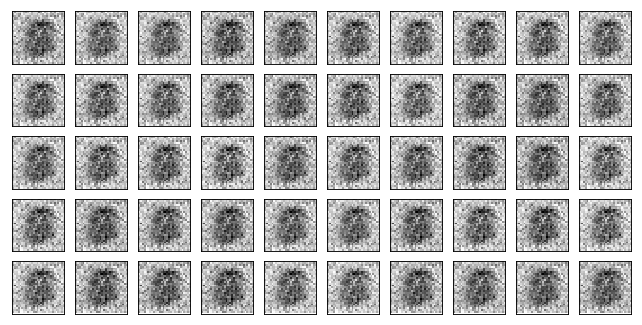

Test losses. G: 0.7132, D: 0.4553
Train Epoch: 2 [0/50000 (0%)]	Losses G: 1.4499, D: 0.4883
Train Epoch: 2 [25000/50000 (50%)]	Losses G: 1.2868, D: 0.5378
Train Epoch: 2 [50000/50000 (100%)]	Losses G: 1.3997, D: 0.5672


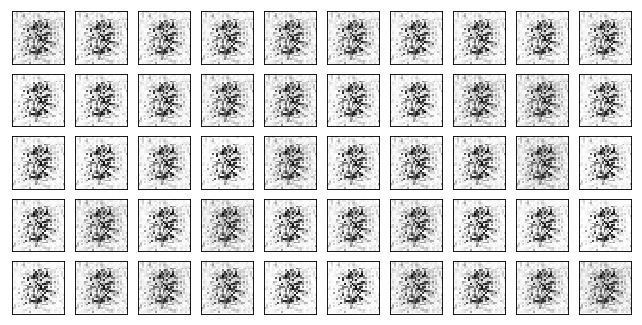

Test losses. G: 0.9063, D: 0.5275
Train Epoch: 3 [0/50000 (0%)]	Losses G: 1.4855, D: 0.5318
Train Epoch: 3 [25000/50000 (50%)]	Losses G: 0.8469, D: 0.8204
Train Epoch: 3 [50000/50000 (100%)]	Losses G: 0.4620, D: 1.1100


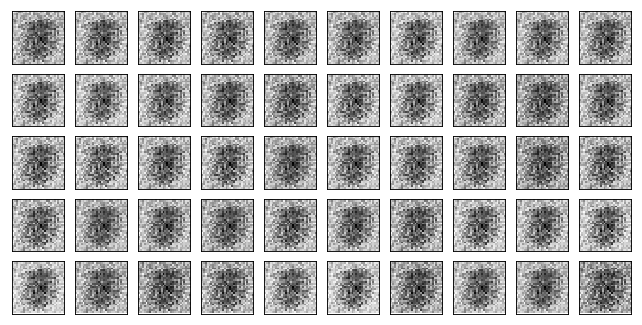

Test losses. G: 0.2206, D: 1.1120
Train Epoch: 4 [0/50000 (0%)]	Losses G: 0.3643, D: 1.1409
Train Epoch: 4 [25000/50000 (50%)]	Losses G: 1.3615, D: 0.4371
Train Epoch: 4 [50000/50000 (100%)]	Losses G: 2.1366, D: 0.5748


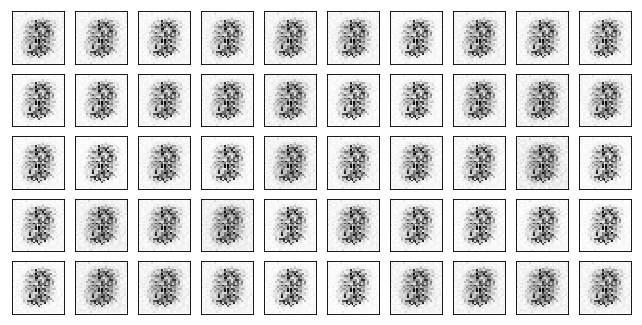

Test losses. G: 1.0317, D: 0.5092
Train Epoch: 5 [0/50000 (0%)]	Losses G: 2.1672, D: 0.6389
Train Epoch: 5 [25000/50000 (50%)]	Losses G: 1.7090, D: 0.3893
Train Epoch: 5 [50000/50000 (100%)]	Losses G: 1.2752, D: 0.4226


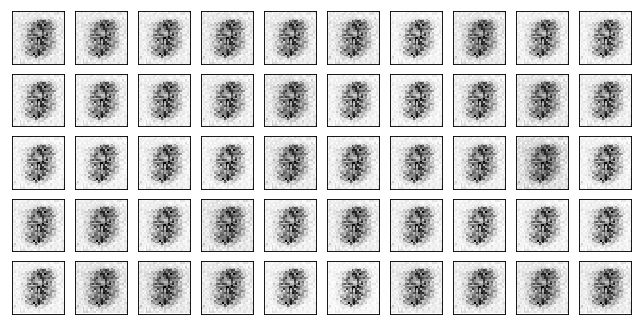

Test losses. G: 1.1119, D: 0.4092
Train Epoch: 6 [0/50000 (0%)]	Losses G: 1.2990, D: 0.4462
Train Epoch: 6 [25000/50000 (50%)]	Losses G: 0.7276, D: 1.0095
Train Epoch: 6 [50000/50000 (100%)]	Losses G: 2.4679, D: 0.1678


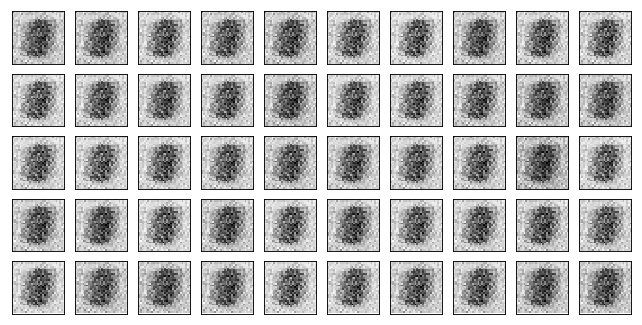

Test losses. G: 1.7966, D: 0.1341
Train Epoch: 7 [0/50000 (0%)]	Losses G: 2.2401, D: 0.1848
Train Epoch: 7 [25000/50000 (50%)]	Losses G: 3.0736, D: 0.2860
Train Epoch: 7 [50000/50000 (100%)]	Losses G: 4.0313, D: 0.1224


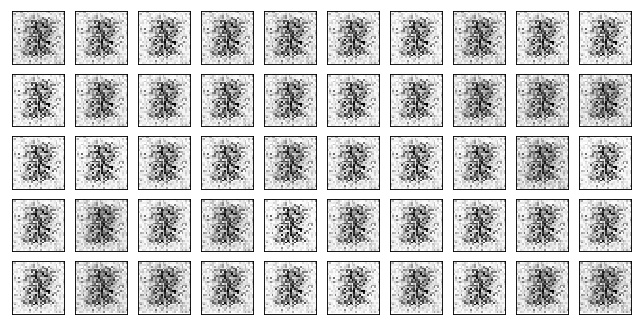

Test losses. G: 2.8594, D: 0.0702
Train Epoch: 8 [0/50000 (0%)]	Losses G: 4.1210, D: 0.1522
Train Epoch: 8 [25000/50000 (50%)]	Losses G: 2.9019, D: 0.1355
Train Epoch: 8 [50000/50000 (100%)]	Losses G: 4.2308, D: 0.2009


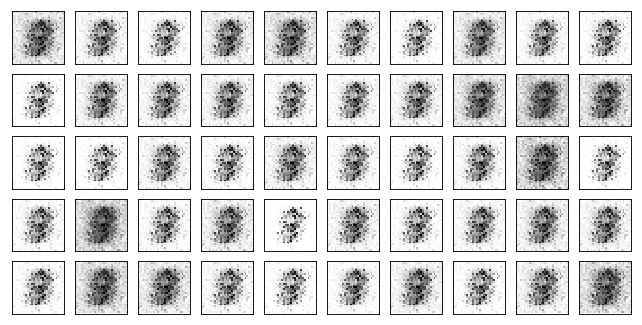

Test losses. G: 3.1249, D: 0.1069
Train Epoch: 9 [0/50000 (0%)]	Losses G: 4.5442, D: 0.2591
Train Epoch: 9 [25000/50000 (50%)]	Losses G: 3.7143, D: 0.1183
Train Epoch: 9 [50000/50000 (100%)]	Losses G: 3.8657, D: 0.1353


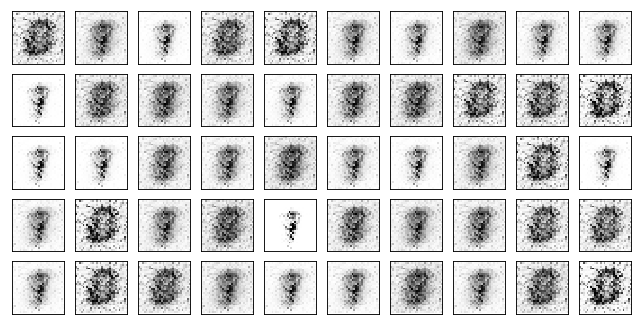

Test losses. G: 3.3540, D: 0.0521
Train Epoch: 10 [0/50000 (0%)]	Losses G: 4.4873, D: 0.1379
Train Epoch: 10 [25000/50000 (50%)]	Losses G: 3.5908, D: 0.1546
Train Epoch: 10 [50000/50000 (100%)]	Losses G: 5.6086, D: 0.0545


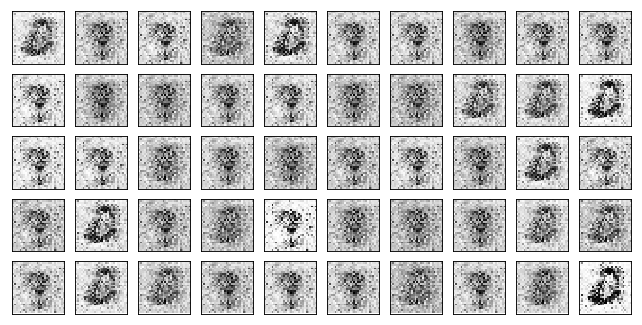

Test losses. G: 4.8653, D: 0.0218
Train Epoch: 11 [0/50000 (0%)]	Losses G: 6.1101, D: 0.0968
Train Epoch: 11 [25000/50000 (50%)]	Losses G: 6.0616, D: 0.0868
Train Epoch: 11 [50000/50000 (100%)]	Losses G: 4.2082, D: 0.1565


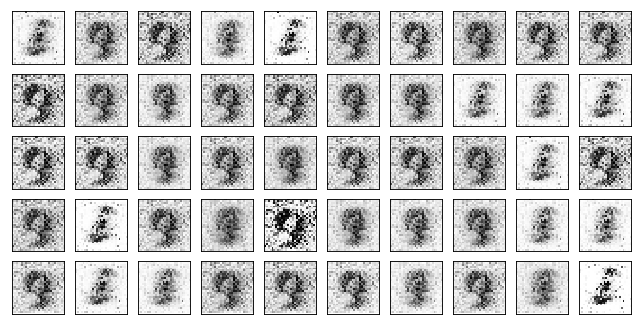

Test losses. G: 3.0671, D: 0.0662
Train Epoch: 12 [0/50000 (0%)]	Losses G: 4.2521, D: 0.1524
Train Epoch: 12 [25000/50000 (50%)]	Losses G: 4.3124, D: 0.1056
Train Epoch: 12 [50000/50000 (100%)]	Losses G: 5.7944, D: 0.0757


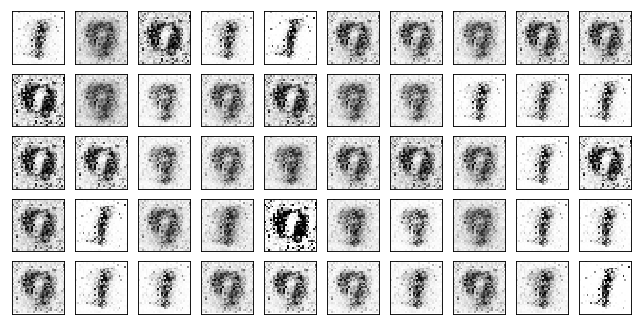

Test losses. G: 5.1684, D: 0.0130
Train Epoch: 13 [0/50000 (0%)]	Losses G: 5.4934, D: 0.0785
Train Epoch: 13 [25000/50000 (50%)]	Losses G: 5.4596, D: 0.1280
Train Epoch: 13 [50000/50000 (100%)]	Losses G: 7.5109, D: 0.0569


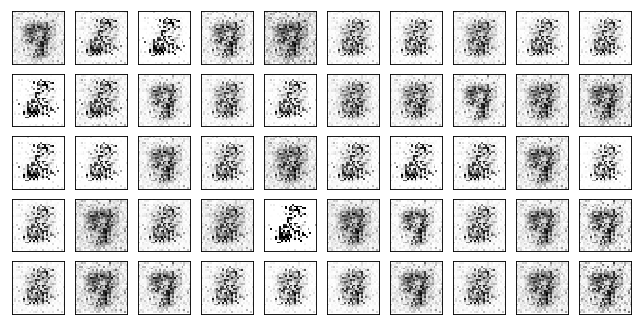

Test losses. G: 6.2246, D: 0.0094
Train Epoch: 14 [0/50000 (0%)]	Losses G: 7.4007, D: 0.0578
Train Epoch: 14 [25000/50000 (50%)]	Losses G: 4.9672, D: 0.1021
Train Epoch: 14 [50000/50000 (100%)]	Losses G: 4.2874, D: 0.0690


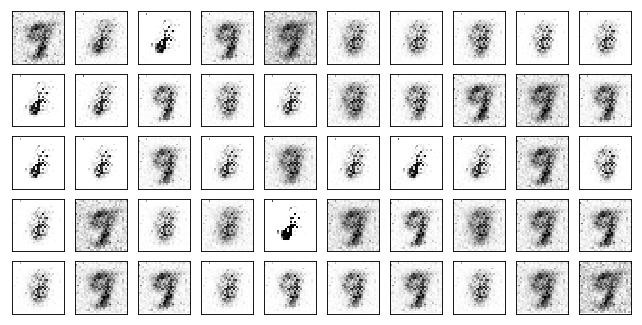

Test losses. G: 4.0987, D: 0.0212
Train Epoch: 15 [0/50000 (0%)]	Losses G: 4.7962, D: 0.0696
Train Epoch: 15 [25000/50000 (50%)]	Losses G: 5.2207, D: 0.0855
Train Epoch: 15 [50000/50000 (100%)]	Losses G: 4.6999, D: 0.2364


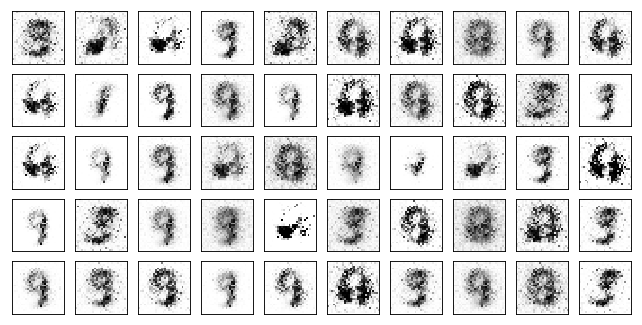

Test losses. G: 3.8555, D: 0.0727
Train Epoch: 16 [0/50000 (0%)]	Losses G: 4.5200, D: 0.1906
Train Epoch: 16 [25000/50000 (50%)]	Losses G: 5.3451, D: 0.1449
Train Epoch: 16 [50000/50000 (100%)]	Losses G: 5.4402, D: 0.1015


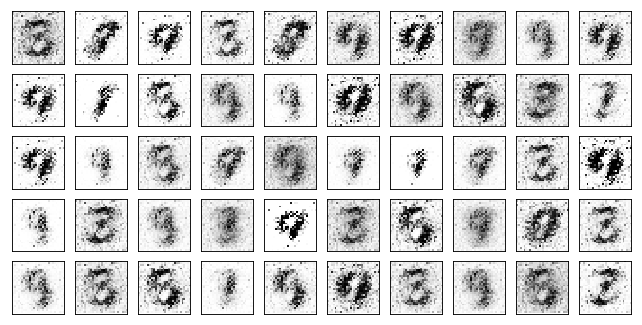

Test losses. G: 4.5410, D: 0.0283
Train Epoch: 17 [0/50000 (0%)]	Losses G: 5.7089, D: 0.0777
Train Epoch: 17 [25000/50000 (50%)]	Losses G: 5.8155, D: 0.1039
Train Epoch: 17 [50000/50000 (100%)]	Losses G: 5.7987, D: 0.1059


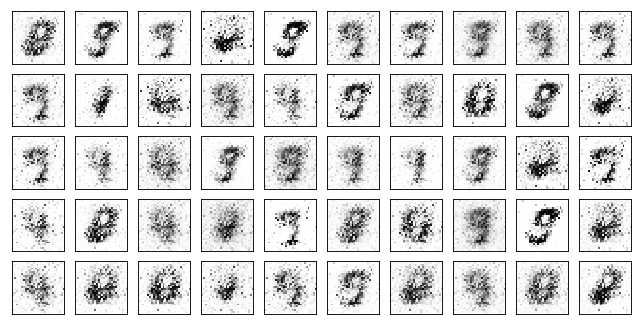

Test losses. G: 4.6029, D: 0.0203
Train Epoch: 18 [0/50000 (0%)]	Losses G: 6.7658, D: 0.0835
Train Epoch: 18 [25000/50000 (50%)]	Losses G: 6.2291, D: 0.0616
Train Epoch: 18 [50000/50000 (100%)]	Losses G: 5.3280, D: 0.0961


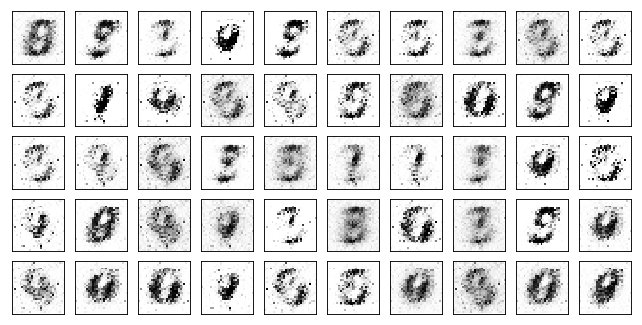

Test losses. G: 4.5389, D: 0.0309
Train Epoch: 19 [0/50000 (0%)]	Losses G: 5.1729, D: 0.1173
Train Epoch: 19 [25000/50000 (50%)]	Losses G: 4.6617, D: 0.1246
Train Epoch: 19 [50000/50000 (100%)]	Losses G: 4.5320, D: 0.2112


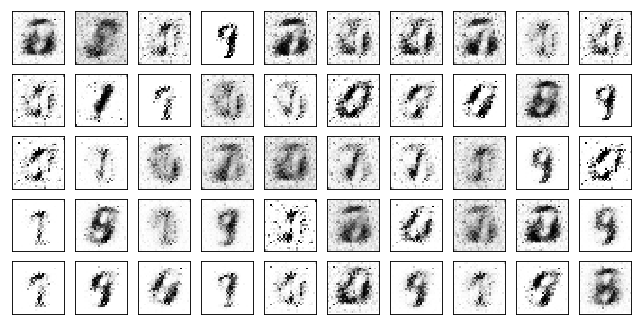

Test losses. G: 3.7711, D: 0.0887
Train Epoch: 20 [0/50000 (0%)]	Losses G: 4.8670, D: 0.2609
Train Epoch: 20 [25000/50000 (50%)]	Losses G: 5.8704, D: 0.0605
Train Epoch: 20 [50000/50000 (100%)]	Losses G: 6.9817, D: 0.1285


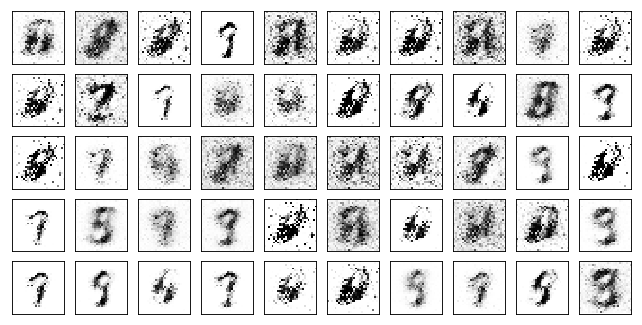

Test losses. G: 5.6207, D: 0.0527
Train Epoch: 21 [0/50000 (0%)]	Losses G: 5.8784, D: 0.0721
Train Epoch: 21 [25000/50000 (50%)]	Losses G: 5.1238, D: 0.0974
Train Epoch: 21 [50000/50000 (100%)]	Losses G: 6.0059, D: 0.1088


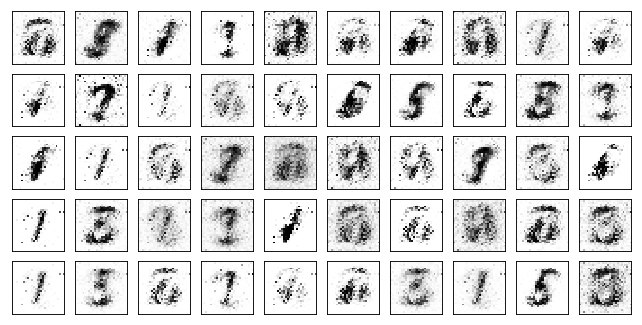

Test losses. G: 5.2543, D: 0.0212
Train Epoch: 22 [0/50000 (0%)]	Losses G: 6.1418, D: 0.0796
Train Epoch: 22 [25000/50000 (50%)]	Losses G: 5.4717, D: 0.0712
Train Epoch: 22 [50000/50000 (100%)]	Losses G: 6.2342, D: 0.0494


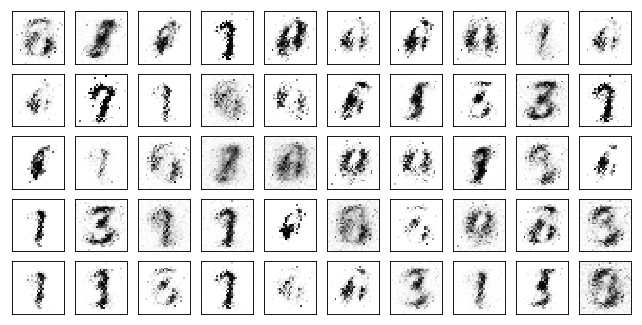

Test losses. G: 5.7227, D: 0.0246
Train Epoch: 23 [0/50000 (0%)]	Losses G: 5.3318, D: 0.0662
Train Epoch: 23 [25000/50000 (50%)]	Losses G: 5.5593, D: 0.0832
Train Epoch: 23 [50000/50000 (100%)]	Losses G: 4.3876, D: 0.0960


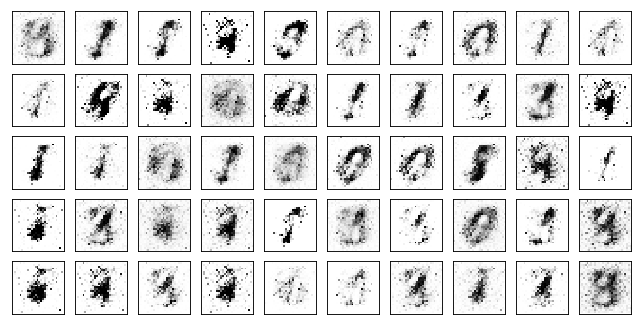

Test losses. G: 3.3996, D: 0.0570
Train Epoch: 24 [0/50000 (0%)]	Losses G: 4.7366, D: 0.1096
Train Epoch: 24 [25000/50000 (50%)]	Losses G: 5.2377, D: 0.0882
Train Epoch: 24 [50000/50000 (100%)]	Losses G: 5.4294, D: 0.0627


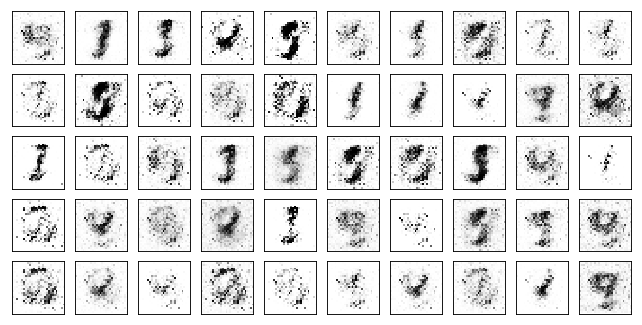

Test losses. G: 4.6855, D: 0.0164
Train Epoch: 25 [0/50000 (0%)]	Losses G: 5.5496, D: 0.0476
Train Epoch: 25 [25000/50000 (50%)]	Losses G: 7.0345, D: 0.0610
Train Epoch: 25 [50000/50000 (100%)]	Losses G: 6.3358, D: 0.0806


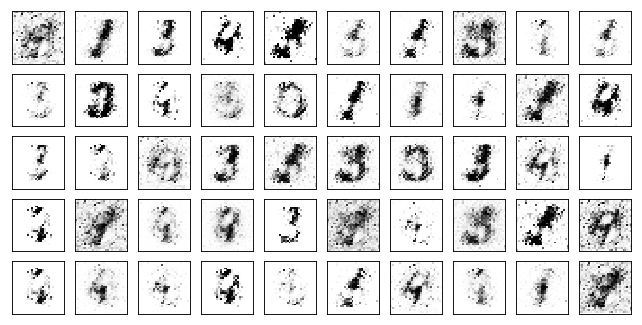

Test losses. G: 5.3723, D: 0.0280
Train Epoch: 26 [0/50000 (0%)]	Losses G: 5.7216, D: 0.0759
Train Epoch: 26 [25000/50000 (50%)]	Losses G: 5.6096, D: 0.0845
Train Epoch: 26 [50000/50000 (100%)]	Losses G: 5.8457, D: 0.1069


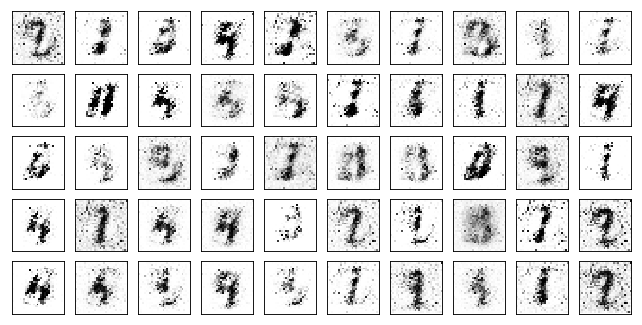

Test losses. G: 5.0770, D: 0.0303
Train Epoch: 27 [0/50000 (0%)]	Losses G: 5.9159, D: 0.0952
Train Epoch: 27 [25000/50000 (50%)]	Losses G: 5.8775, D: 0.0713
Train Epoch: 27 [50000/50000 (100%)]	Losses G: 6.8598, D: 0.0523


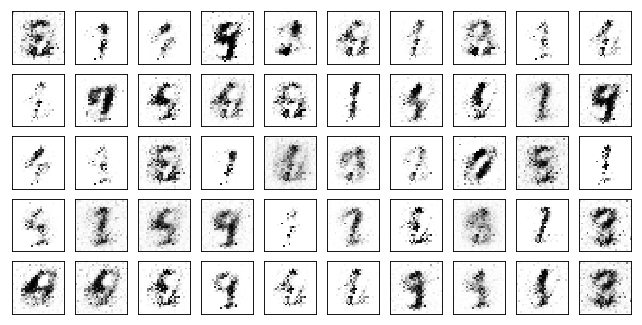

Test losses. G: 6.1894, D: 0.0205
Train Epoch: 28 [0/50000 (0%)]	Losses G: 6.0552, D: 0.0816
Train Epoch: 28 [25000/50000 (50%)]	Losses G: 5.3423, D: 0.0851
Train Epoch: 28 [50000/50000 (100%)]	Losses G: 6.4977, D: 0.0588


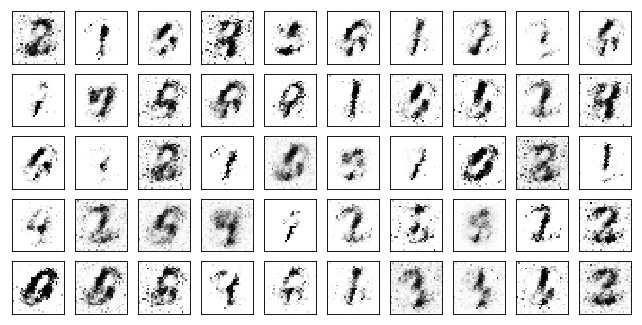

Test losses. G: 5.9389, D: 0.0334
Train Epoch: 29 [0/50000 (0%)]	Losses G: 5.8075, D: 0.0966
Train Epoch: 29 [25000/50000 (50%)]	Losses G: 6.4323, D: 0.0744
Train Epoch: 29 [50000/50000 (100%)]	Losses G: 6.6145, D: 0.0911


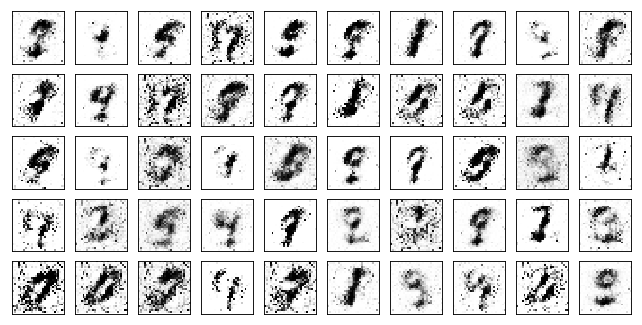

Test losses. G: 5.5869, D: 0.0545
Train Epoch: 30 [0/50000 (0%)]	Losses G: 6.2392, D: 0.1272
Train Epoch: 30 [25000/50000 (50%)]	Losses G: 5.4037, D: 0.0945
Train Epoch: 30 [50000/50000 (100%)]	Losses G: 4.6409, D: 0.0848


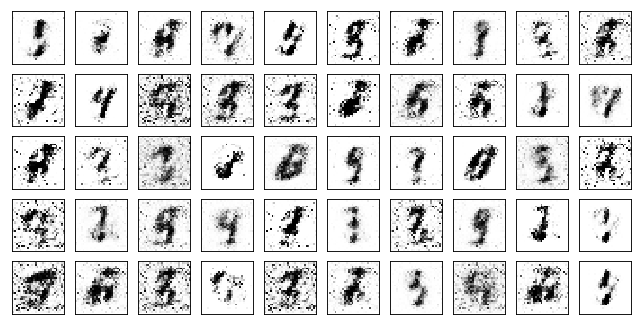

Test losses. G: 3.7041, D: 0.0466
Train Epoch: 31 [0/50000 (0%)]	Losses G: 6.2005, D: 0.1237
Train Epoch: 31 [25000/50000 (50%)]	Losses G: 5.5837, D: 0.1320
Train Epoch: 31 [50000/50000 (100%)]	Losses G: 5.0892, D: 0.0825


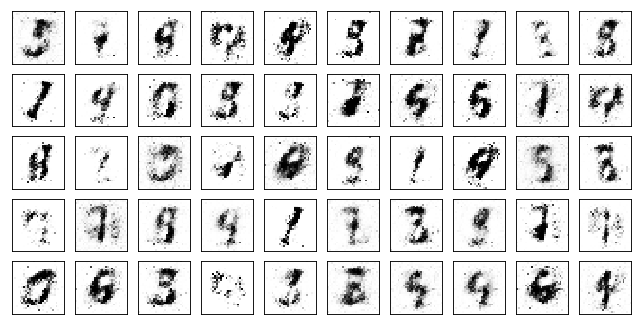

Test losses. G: 4.5791, D: 0.0364
Train Epoch: 32 [0/50000 (0%)]	Losses G: 4.2876, D: 0.1092
Train Epoch: 32 [25000/50000 (50%)]	Losses G: 3.9904, D: 0.1038
Train Epoch: 32 [50000/50000 (100%)]	Losses G: 5.0203, D: 0.0882


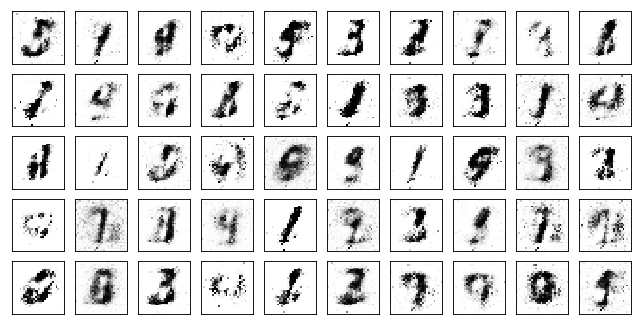

Test losses. G: 4.6059, D: 0.0417
Train Epoch: 33 [0/50000 (0%)]	Losses G: 4.6977, D: 0.1070
Train Epoch: 33 [25000/50000 (50%)]	Losses G: 4.3437, D: 0.1278
Train Epoch: 33 [50000/50000 (100%)]	Losses G: 6.2414, D: 0.0803


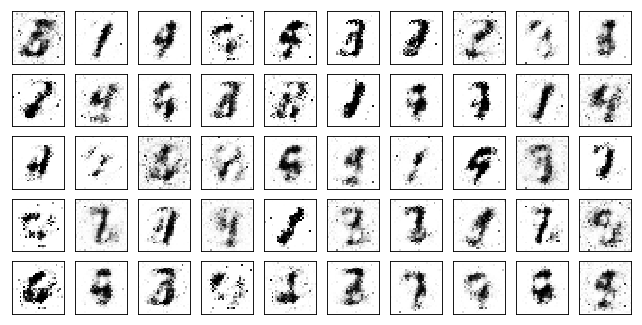

Test losses. G: 5.6695, D: 0.0587
Train Epoch: 34 [0/50000 (0%)]	Losses G: 5.4348, D: 0.1330
Train Epoch: 34 [25000/50000 (50%)]	Losses G: 4.5678, D: 0.1266
Train Epoch: 34 [50000/50000 (100%)]	Losses G: 4.7469, D: 0.1098


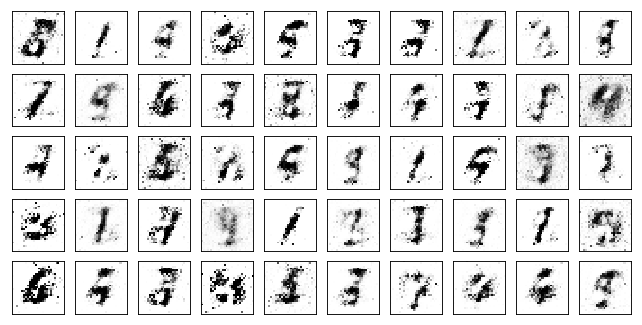

Test losses. G: 4.2275, D: 0.0333
Train Epoch: 35 [0/50000 (0%)]	Losses G: 5.0417, D: 0.1136
Train Epoch: 35 [25000/50000 (50%)]	Losses G: 4.7976, D: 0.1471
Train Epoch: 35 [50000/50000 (100%)]	Losses G: 3.9766, D: 0.1403


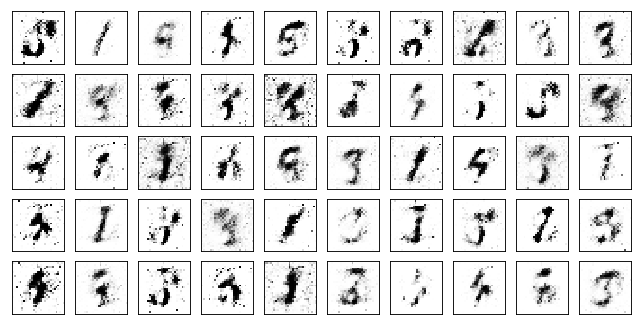

Test losses. G: 3.3638, D: 0.0696
Train Epoch: 36 [0/50000 (0%)]	Losses G: 3.8371, D: 0.1524
Train Epoch: 36 [25000/50000 (50%)]	Losses G: 4.6320, D: 0.0794
Train Epoch: 36 [50000/50000 (100%)]	Losses G: 3.8337, D: 0.2379


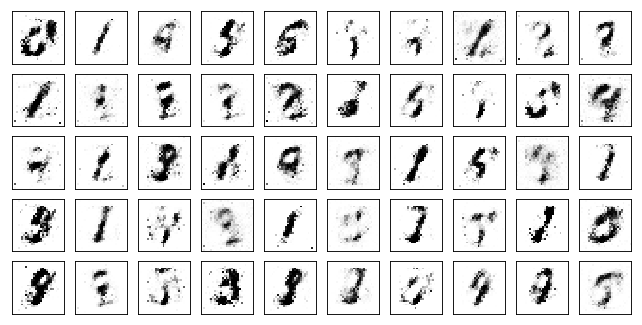

Test losses. G: 3.3852, D: 0.1055
Train Epoch: 37 [0/50000 (0%)]	Losses G: 3.4244, D: 0.1728
Train Epoch: 37 [25000/50000 (50%)]	Losses G: 4.1555, D: 0.1454
Train Epoch: 37 [50000/50000 (100%)]	Losses G: 3.7415, D: 0.1288


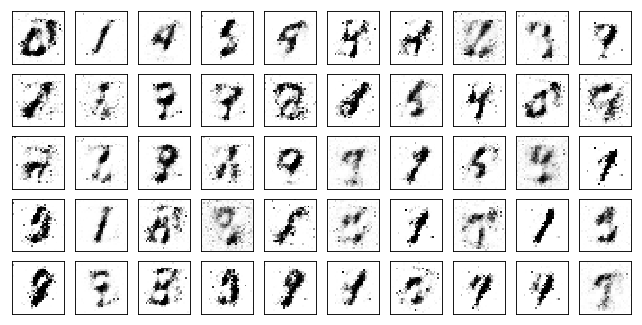

Test losses. G: 3.2840, D: 0.0644
Train Epoch: 38 [0/50000 (0%)]	Losses G: 4.4075, D: 0.1095
Train Epoch: 38 [25000/50000 (50%)]	Losses G: 4.7919, D: 0.1145
Train Epoch: 38 [50000/50000 (100%)]	Losses G: 4.0315, D: 0.1316


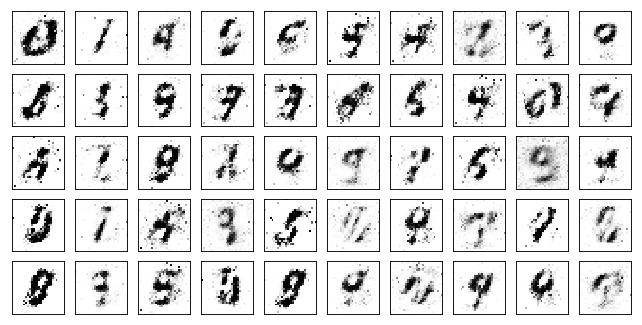

Test losses. G: 3.6489, D: 0.0731
Train Epoch: 39 [0/50000 (0%)]	Losses G: 4.2294, D: 0.1471
Train Epoch: 39 [25000/50000 (50%)]	Losses G: 4.8053, D: 0.1398
Train Epoch: 39 [50000/50000 (100%)]	Losses G: 5.2782, D: 0.1170


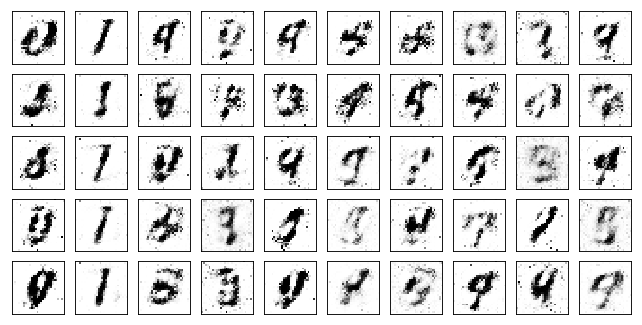

Test losses. G: 4.8483, D: 0.1110
Train Epoch: 40 [0/50000 (0%)]	Losses G: 3.9998, D: 0.2126
Train Epoch: 40 [25000/50000 (50%)]	Losses G: 3.2973, D: 0.2248
Train Epoch: 40 [50000/50000 (100%)]	Losses G: 4.2537, D: 0.2328


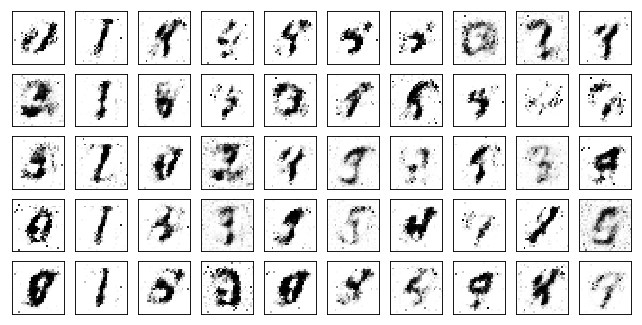

Test losses. G: 3.7153, D: 0.1048
Train Epoch: 41 [0/50000 (0%)]	Losses G: 3.6792, D: 0.2097
Train Epoch: 41 [25000/50000 (50%)]	Losses G: 3.3371, D: 0.1477
Train Epoch: 41 [50000/50000 (100%)]	Losses G: 3.5212, D: 0.2479


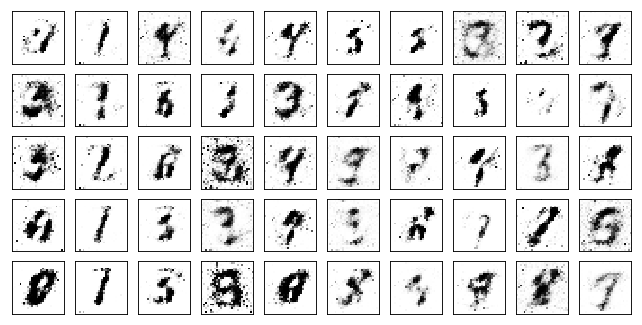

Test losses. G: 3.0724, D: 0.1377
Train Epoch: 42 [0/50000 (0%)]	Losses G: 2.9992, D: 0.2116
Train Epoch: 42 [25000/50000 (50%)]	Losses G: 3.3253, D: 0.2115
Train Epoch: 42 [50000/50000 (100%)]	Losses G: 3.9001, D: 0.1378


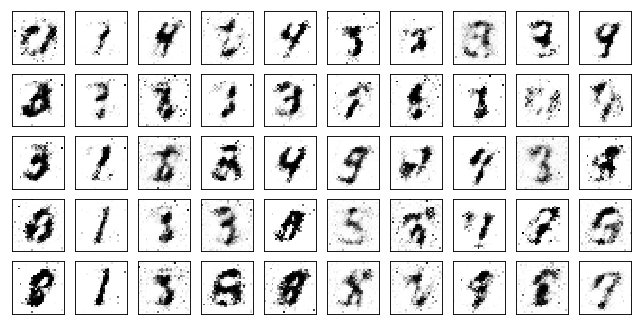

Test losses. G: 3.5499, D: 0.0868
Train Epoch: 43 [0/50000 (0%)]	Losses G: 3.3610, D: 0.1864
Train Epoch: 43 [25000/50000 (50%)]	Losses G: 3.5417, D: 0.2499
Train Epoch: 43 [50000/50000 (100%)]	Losses G: 3.0311, D: 0.1777


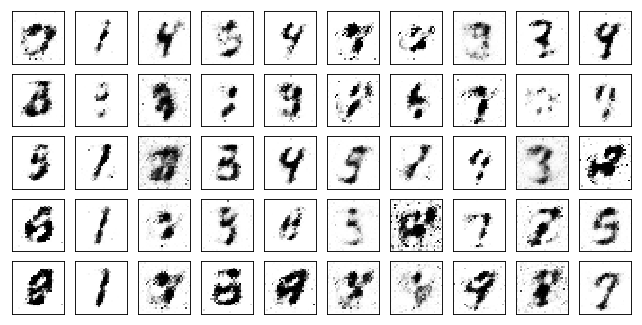

Test losses. G: 2.8254, D: 0.1204
Train Epoch: 44 [0/50000 (0%)]	Losses G: 3.6793, D: 0.1750
Train Epoch: 44 [25000/50000 (50%)]	Losses G: 2.8684, D: 0.2094
Train Epoch: 44 [50000/50000 (100%)]	Losses G: 4.0477, D: 0.1791


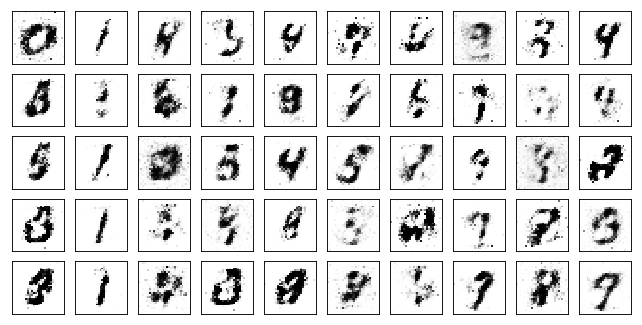

Test losses. G: 3.7700, D: 0.0910
Train Epoch: 45 [0/50000 (0%)]	Losses G: 4.1832, D: 0.1832
Train Epoch: 45 [25000/50000 (50%)]	Losses G: 3.7483, D: 0.2218
Train Epoch: 45 [50000/50000 (100%)]	Losses G: 3.6960, D: 0.2516


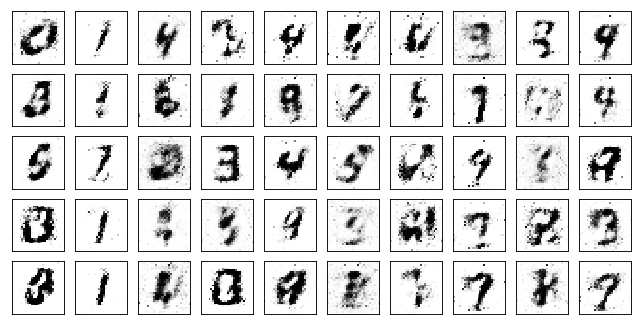

Test losses. G: 3.3879, D: 0.1685
Train Epoch: 46 [0/50000 (0%)]	Losses G: 3.2086, D: 0.2276
Train Epoch: 46 [25000/50000 (50%)]	Losses G: 2.5591, D: 0.2625
Train Epoch: 46 [50000/50000 (100%)]	Losses G: 2.3169, D: 0.2294


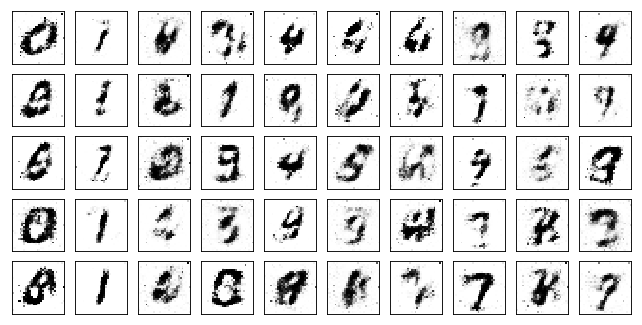

Test losses. G: 2.2878, D: 0.1695
Train Epoch: 47 [0/50000 (0%)]	Losses G: 2.9469, D: 0.2847
Train Epoch: 47 [25000/50000 (50%)]	Losses G: 3.2078, D: 0.2402
Train Epoch: 47 [50000/50000 (100%)]	Losses G: 3.6999, D: 0.1944


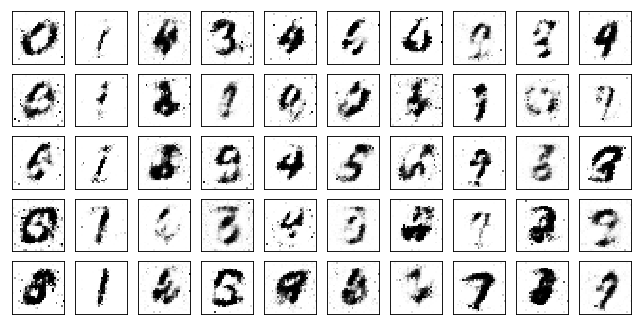

Test losses. G: 3.3363, D: 0.0937
Train Epoch: 48 [0/50000 (0%)]	Losses G: 4.1231, D: 0.1700
Train Epoch: 48 [25000/50000 (50%)]	Losses G: 3.4950, D: 0.2150
Train Epoch: 48 [50000/50000 (100%)]	Losses G: 3.5323, D: 0.1963


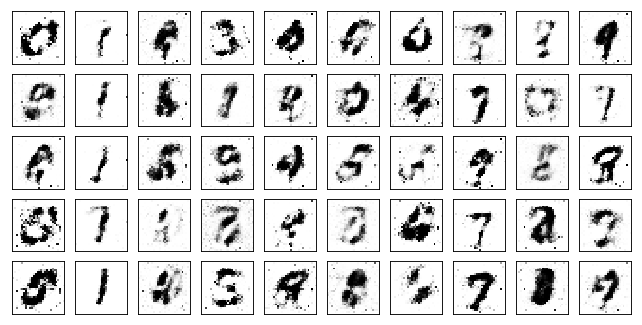

Test losses. G: 3.1748, D: 0.1194
Train Epoch: 49 [0/50000 (0%)]	Losses G: 3.3984, D: 0.2237
Train Epoch: 49 [25000/50000 (50%)]	Losses G: 2.9355, D: 0.2410
Train Epoch: 49 [50000/50000 (100%)]	Losses G: 3.0294, D: 0.2699


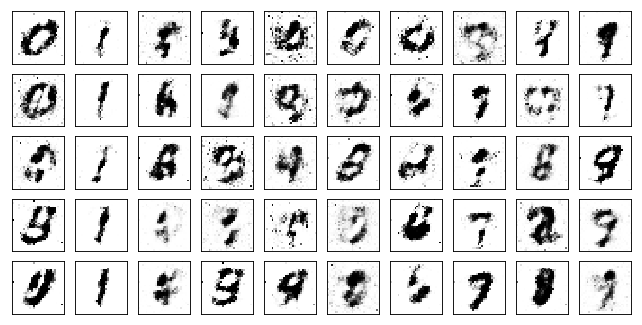

Test losses. G: 2.8230, D: 0.1675
Train Epoch: 50 [0/50000 (0%)]	Losses G: 2.7959, D: 0.2138
Train Epoch: 50 [25000/50000 (50%)]	Losses G: 3.0019, D: 0.2316
Train Epoch: 50 [50000/50000 (100%)]	Losses G: 2.6582, D: 0.2069


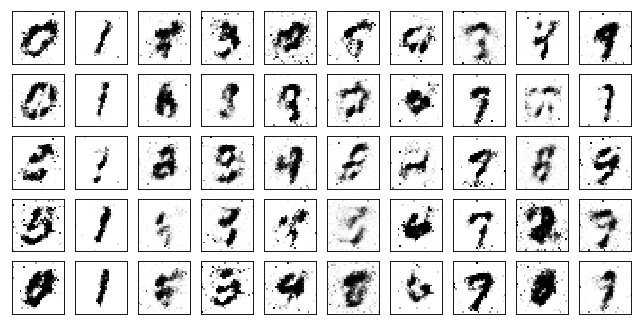

Test losses. G: 2.5484, D: 0.1344
Train Epoch: 51 [0/50000 (0%)]	Losses G: 2.9631, D: 0.2587
Train Epoch: 51 [25000/50000 (50%)]	Losses G: 2.7581, D: 0.2468
Train Epoch: 51 [50000/50000 (100%)]	Losses G: 2.4708, D: 0.3198


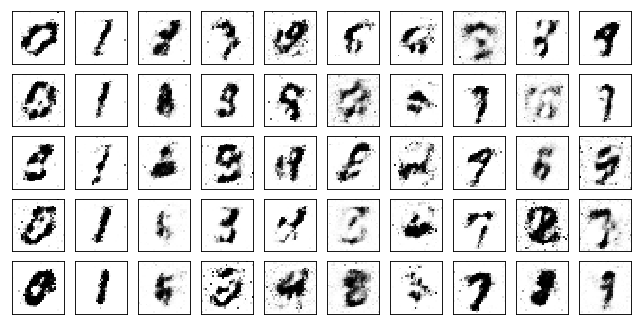

Test losses. G: 2.3714, D: 0.1786
Train Epoch: 52 [0/50000 (0%)]	Losses G: 3.1992, D: 0.2957
Train Epoch: 52 [25000/50000 (50%)]	Losses G: 2.6617, D: 0.2724
Train Epoch: 52 [50000/50000 (100%)]	Losses G: 3.2672, D: 0.2210


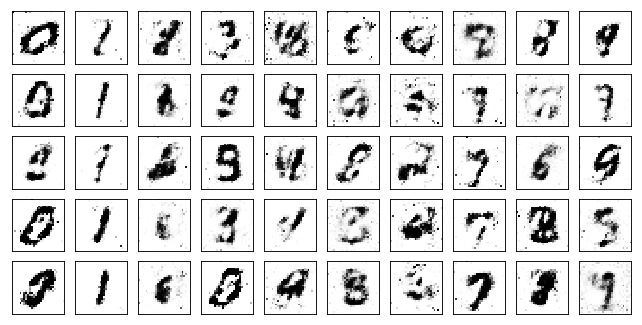

Test losses. G: 2.9299, D: 0.1802
Train Epoch: 53 [0/50000 (0%)]	Losses G: 3.0503, D: 0.2538
Train Epoch: 53 [25000/50000 (50%)]	Losses G: 3.4033, D: 0.2168
Train Epoch: 53 [50000/50000 (100%)]	Losses G: 3.6448, D: 0.1776


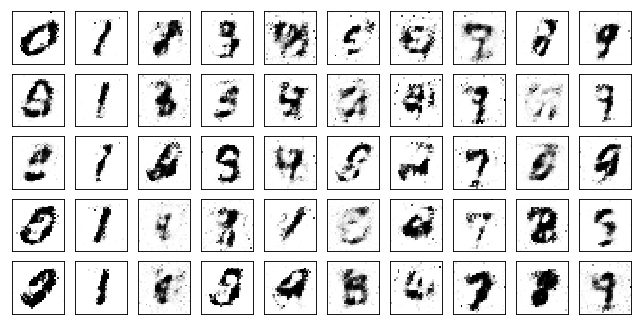

Test losses. G: 3.4143, D: 0.1094
Train Epoch: 54 [0/50000 (0%)]	Losses G: 3.5897, D: 0.1263
Train Epoch: 54 [25000/50000 (50%)]	Losses G: 3.1378, D: 0.2333
Train Epoch: 54 [50000/50000 (100%)]	Losses G: 2.5755, D: 0.3207


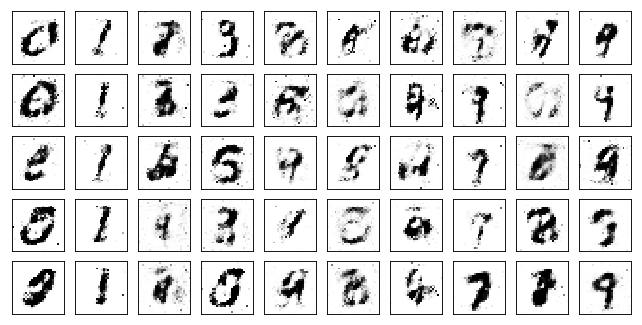

Test losses. G: 2.3177, D: 0.1811
Train Epoch: 55 [0/50000 (0%)]	Losses G: 2.6850, D: 0.2627
Train Epoch: 55 [25000/50000 (50%)]	Losses G: 2.8744, D: 0.2636
Train Epoch: 55 [50000/50000 (100%)]	Losses G: 2.6874, D: 0.1976


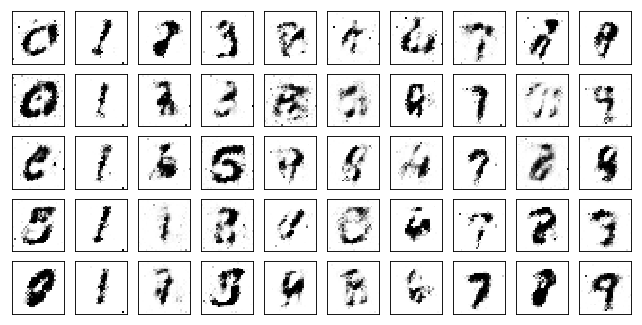

Test losses. G: 2.7032, D: 0.1315
Train Epoch: 56 [0/50000 (0%)]	Losses G: 3.2529, D: 0.1819
Train Epoch: 56 [25000/50000 (50%)]	Losses G: 2.8659, D: 0.2484
Train Epoch: 56 [50000/50000 (100%)]	Losses G: 2.7876, D: 0.2120


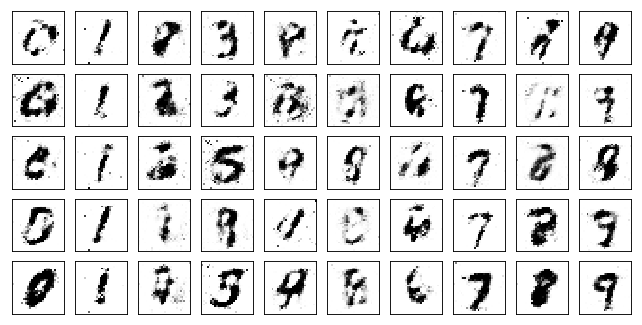

Test losses. G: 2.6033, D: 0.1312
Train Epoch: 57 [0/50000 (0%)]	Losses G: 2.9393, D: 0.2210
Train Epoch: 57 [25000/50000 (50%)]	Losses G: 3.3429, D: 0.2024
Train Epoch: 57 [50000/50000 (100%)]	Losses G: 3.2638, D: 0.2294


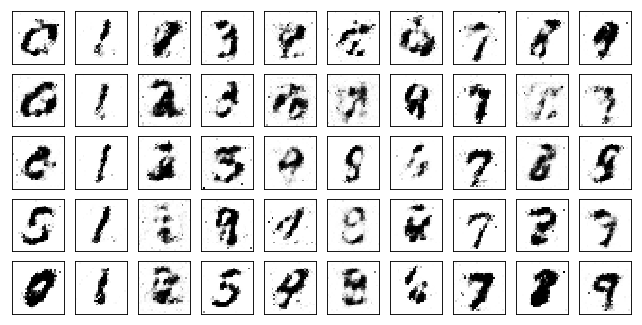

Test losses. G: 3.1752, D: 0.1318
Train Epoch: 58 [0/50000 (0%)]	Losses G: 3.2147, D: 0.2278
Train Epoch: 58 [25000/50000 (50%)]	Losses G: 3.2065, D: 0.2439
Train Epoch: 58 [50000/50000 (100%)]	Losses G: 2.6881, D: 0.2472


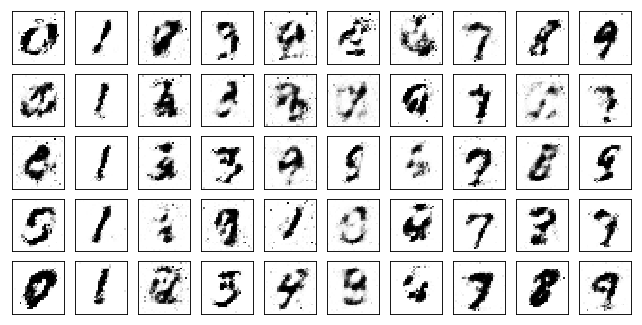

Test losses. G: 2.4518, D: 0.1601
Train Epoch: 59 [0/50000 (0%)]	Losses G: 2.9576, D: 0.2653
Train Epoch: 59 [25000/50000 (50%)]	Losses G: 2.7291, D: 0.2258
Train Epoch: 59 [50000/50000 (100%)]	Losses G: 3.1246, D: 0.2394


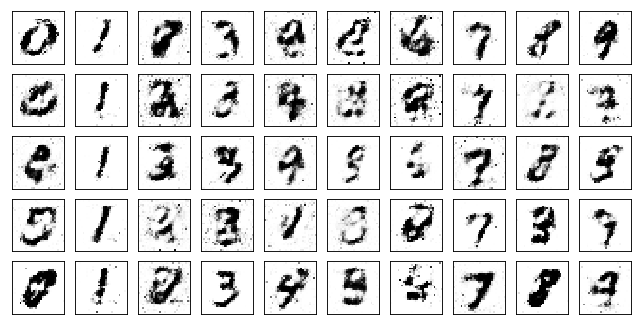

Test losses. G: 2.9878, D: 0.1907
Train Epoch: 60 [0/50000 (0%)]	Losses G: 2.8396, D: 0.2833
Train Epoch: 60 [25000/50000 (50%)]	Losses G: 2.6661, D: 0.3117
Train Epoch: 60 [50000/50000 (100%)]	Losses G: 2.5108, D: 0.2736


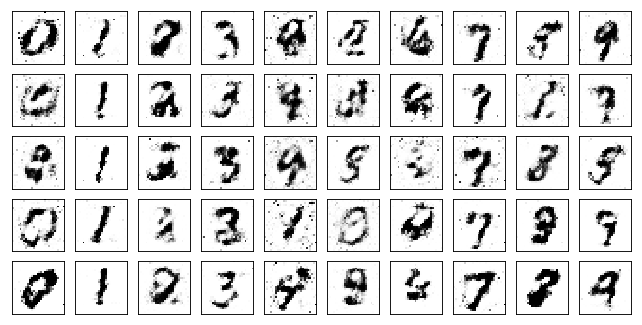

Test losses. G: 2.4783, D: 0.1671
Train Epoch: 61 [0/50000 (0%)]	Losses G: 2.7778, D: 0.2872
Train Epoch: 61 [25000/50000 (50%)]	Losses G: 2.8745, D: 0.1970
Train Epoch: 61 [50000/50000 (100%)]	Losses G: 2.7407, D: 0.2259


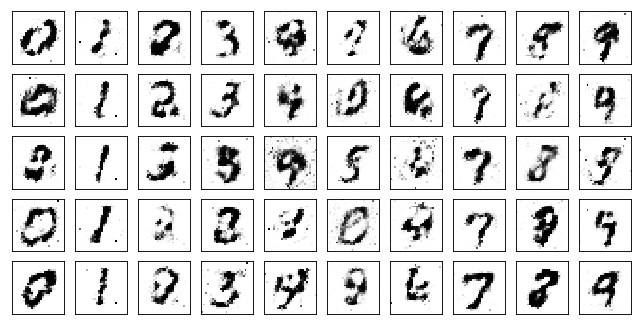

Test losses. G: 2.7038, D: 0.1512
Train Epoch: 62 [0/50000 (0%)]	Losses G: 2.9050, D: 0.2595
Train Epoch: 62 [25000/50000 (50%)]	Losses G: 2.5148, D: 0.2222
Train Epoch: 62 [50000/50000 (100%)]	Losses G: 3.1961, D: 0.2807


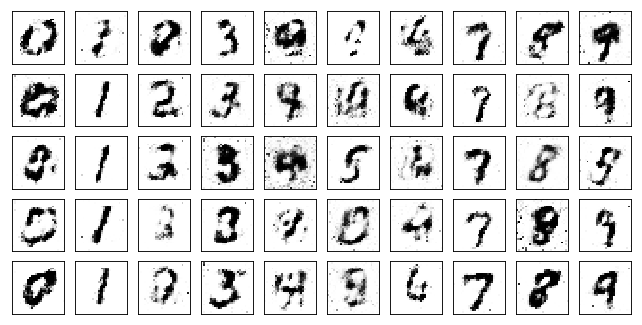

Test losses. G: 3.0993, D: 0.2018
Train Epoch: 63 [0/50000 (0%)]	Losses G: 2.8791, D: 0.2696
Train Epoch: 63 [25000/50000 (50%)]	Losses G: 2.6414, D: 0.3698
Train Epoch: 63 [50000/50000 (100%)]	Losses G: 1.9879, D: 0.4072


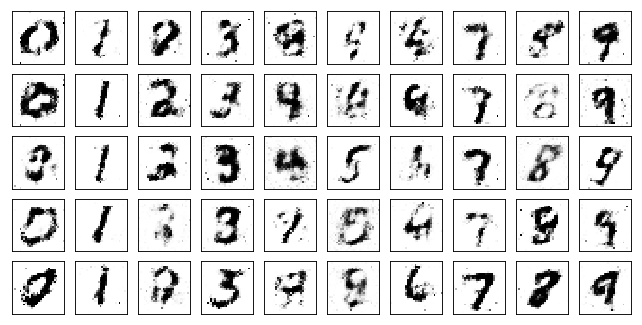

Test losses. G: 1.9683, D: 0.2345
Train Epoch: 64 [0/50000 (0%)]	Losses G: 1.4837, D: 0.3045
Train Epoch: 64 [25000/50000 (50%)]	Losses G: 2.2863, D: 0.3942
Train Epoch: 64 [50000/50000 (100%)]	Losses G: 2.2630, D: 0.3079


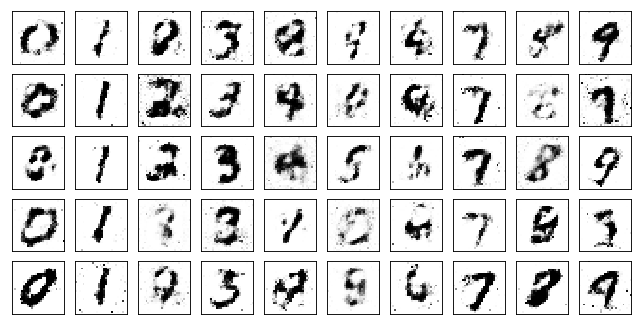

Test losses. G: 2.1161, D: 0.2519
Train Epoch: 65 [0/50000 (0%)]	Losses G: 2.2191, D: 0.3618
Train Epoch: 65 [25000/50000 (50%)]	Losses G: 2.8645, D: 0.3123
Train Epoch: 65 [50000/50000 (100%)]	Losses G: 2.4988, D: 0.2642


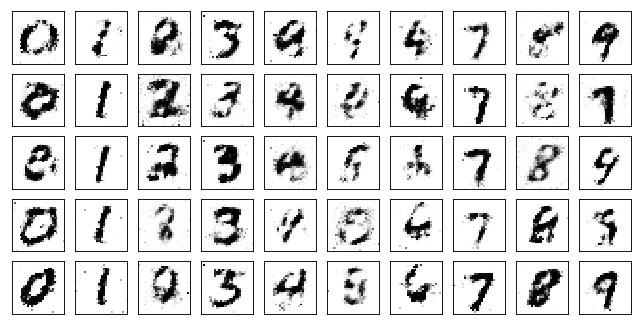

Test losses. G: 2.5409, D: 0.1674
Train Epoch: 66 [0/50000 (0%)]	Losses G: 2.4977, D: 0.2492
Train Epoch: 66 [25000/50000 (50%)]	Losses G: 2.3892, D: 0.3234
Train Epoch: 66 [50000/50000 (100%)]	Losses G: 2.3691, D: 0.2967


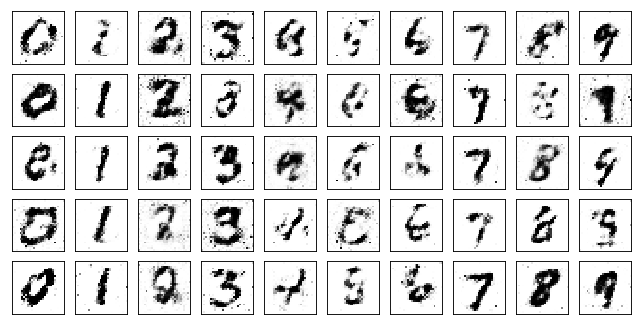

Test losses. G: 2.2355, D: 0.2072
Train Epoch: 67 [0/50000 (0%)]	Losses G: 2.1591, D: 0.3143
Train Epoch: 67 [25000/50000 (50%)]	Losses G: 2.4371, D: 0.3032
Train Epoch: 67 [50000/50000 (100%)]	Losses G: 2.1680, D: 0.3334


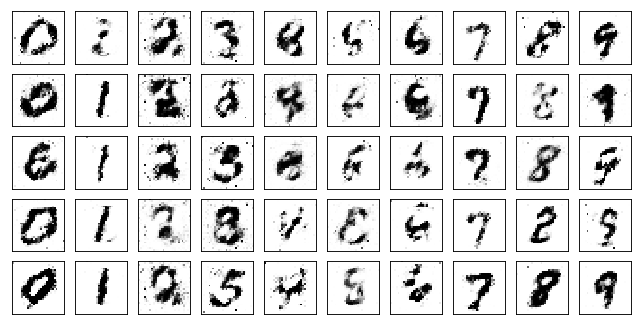

Test losses. G: 2.1209, D: 0.2283
Train Epoch: 68 [0/50000 (0%)]	Losses G: 2.2198, D: 0.3260
Train Epoch: 68 [25000/50000 (50%)]	Losses G: 2.9777, D: 0.2647
Train Epoch: 68 [50000/50000 (100%)]	Losses G: 2.1322, D: 0.3548


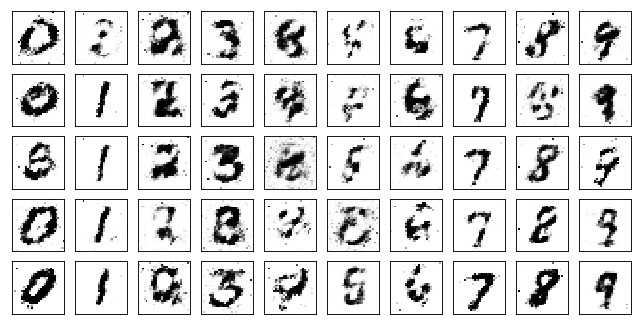

Test losses. G: 1.9905, D: 0.2406
Train Epoch: 69 [0/50000 (0%)]	Losses G: 2.0489, D: 0.3478
Train Epoch: 69 [25000/50000 (50%)]	Losses G: 2.1304, D: 0.3276
Train Epoch: 69 [50000/50000 (100%)]	Losses G: 2.5292, D: 0.2874


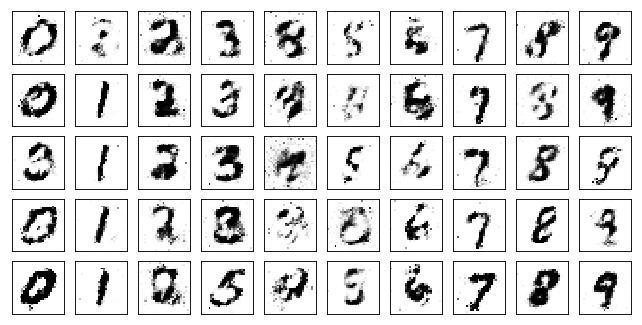

Test losses. G: 2.5551, D: 0.1735
Train Epoch: 70 [0/50000 (0%)]	Losses G: 2.5697, D: 0.2427
Train Epoch: 70 [25000/50000 (50%)]	Losses G: 2.2084, D: 0.3703
Train Epoch: 70 [50000/50000 (100%)]	Losses G: 2.2578, D: 0.2927


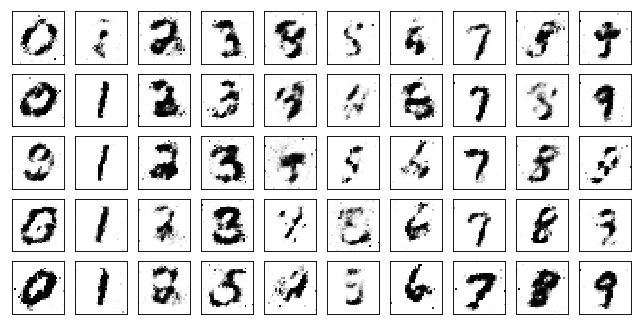

Test losses. G: 2.2155, D: 0.1860
Train Epoch: 71 [0/50000 (0%)]	Losses G: 2.5469, D: 0.2600
Train Epoch: 71 [25000/50000 (50%)]	Losses G: 2.3021, D: 0.3106
Train Epoch: 71 [50000/50000 (100%)]	Losses G: 2.2367, D: 0.2682


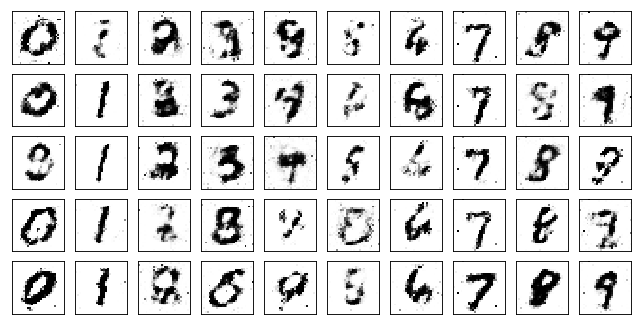

Test losses. G: 2.3606, D: 0.2082
Train Epoch: 72 [0/50000 (0%)]	Losses G: 2.4763, D: 0.2773
Train Epoch: 72 [25000/50000 (50%)]	Losses G: 2.4997, D: 0.3331
Train Epoch: 72 [50000/50000 (100%)]	Losses G: 2.3992, D: 0.3156


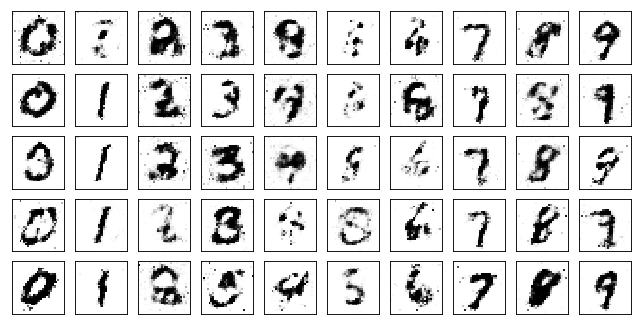

Test losses. G: 2.3467, D: 0.2141
Train Epoch: 73 [0/50000 (0%)]	Losses G: 2.4940, D: 0.2544
Train Epoch: 73 [25000/50000 (50%)]	Losses G: 3.3080, D: 0.3082
Train Epoch: 73 [50000/50000 (100%)]	Losses G: 2.0477, D: 0.3861


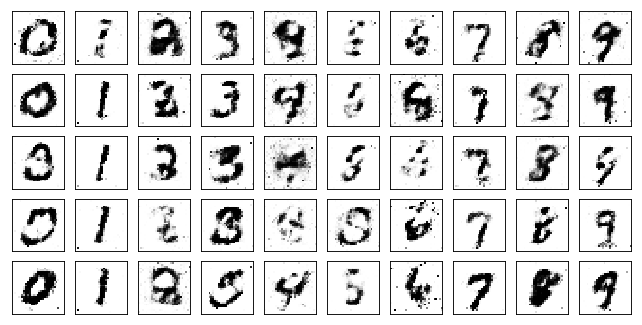

Test losses. G: 2.0191, D: 0.2568
Train Epoch: 74 [0/50000 (0%)]	Losses G: 1.9653, D: 0.3797
Train Epoch: 74 [25000/50000 (50%)]	Losses G: 2.5423, D: 0.2638
Train Epoch: 74 [50000/50000 (100%)]	Losses G: 2.5597, D: 0.3089


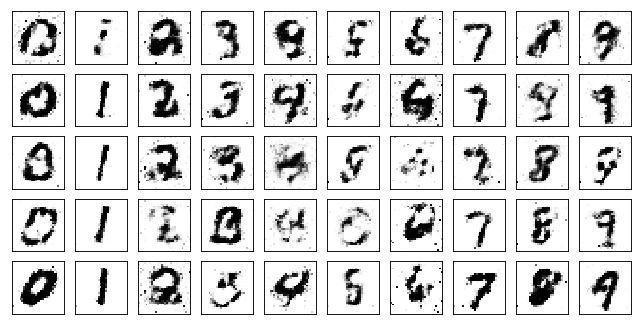

Test losses. G: 2.2834, D: 0.2199
Train Epoch: 75 [0/50000 (0%)]	Losses G: 2.6940, D: 0.3590
Train Epoch: 75 [25000/50000 (50%)]	Losses G: 2.3516, D: 0.3861
Train Epoch: 75 [50000/50000 (100%)]	Losses G: 2.1265, D: 0.4148


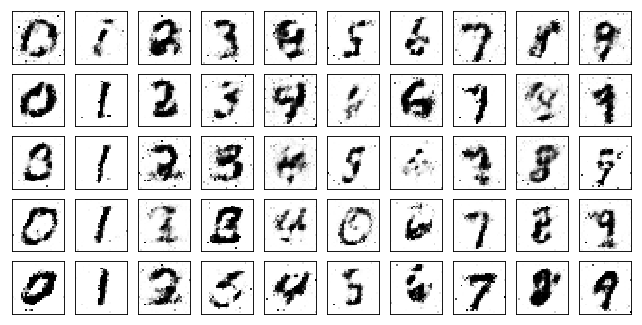

Test losses. G: 2.0940, D: 0.2713
Train Epoch: 76 [0/50000 (0%)]	Losses G: 2.4618, D: 0.3405
Train Epoch: 76 [25000/50000 (50%)]	Losses G: 2.4410, D: 0.3075
Train Epoch: 76 [50000/50000 (100%)]	Losses G: 2.6854, D: 0.3411


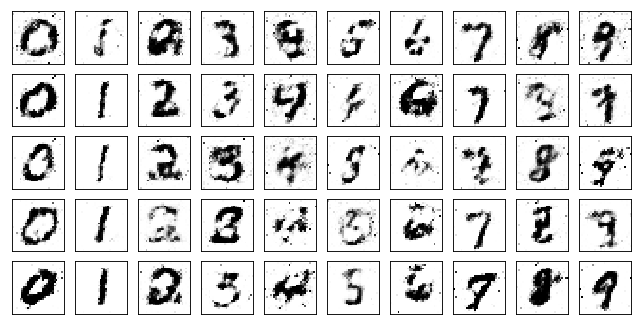

Test losses. G: 2.4119, D: 0.2363
Train Epoch: 77 [0/50000 (0%)]	Losses G: 2.7426, D: 0.3391
Train Epoch: 77 [25000/50000 (50%)]	Losses G: 2.5208, D: 0.3506
Train Epoch: 77 [50000/50000 (100%)]	Losses G: 2.3353, D: 0.3227


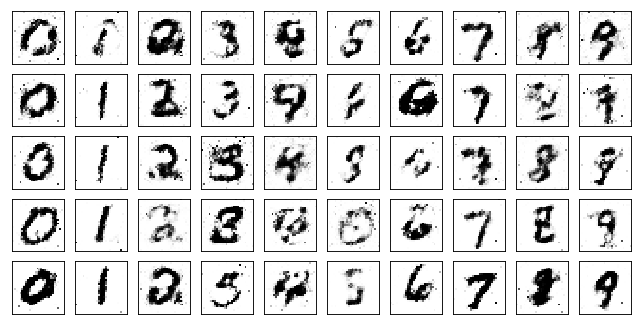

Test losses. G: 2.3210, D: 0.2332
Train Epoch: 78 [0/50000 (0%)]	Losses G: 2.4852, D: 0.3294
Train Epoch: 78 [25000/50000 (50%)]	Losses G: 2.1848, D: 0.3043
Train Epoch: 78 [50000/50000 (100%)]	Losses G: 2.4402, D: 0.3464


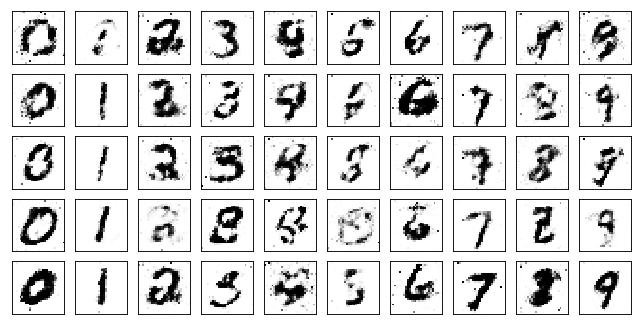

Test losses. G: 2.3265, D: 0.2708
Train Epoch: 79 [0/50000 (0%)]	Losses G: 1.8276, D: 0.4078
Train Epoch: 79 [25000/50000 (50%)]	Losses G: 2.2507, D: 0.3295
Train Epoch: 79 [50000/50000 (100%)]	Losses G: 2.1317, D: 0.3525


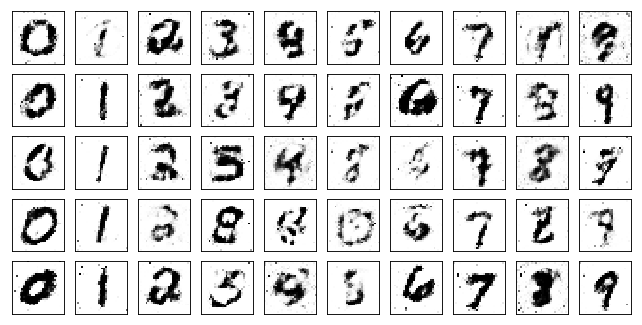

Test losses. G: 2.0172, D: 0.2505
Train Epoch: 80 [0/50000 (0%)]	Losses G: 2.2760, D: 0.3780
Train Epoch: 80 [25000/50000 (50%)]	Losses G: 2.4783, D: 0.2860
Train Epoch: 80 [50000/50000 (100%)]	Losses G: 1.9777, D: 0.3508


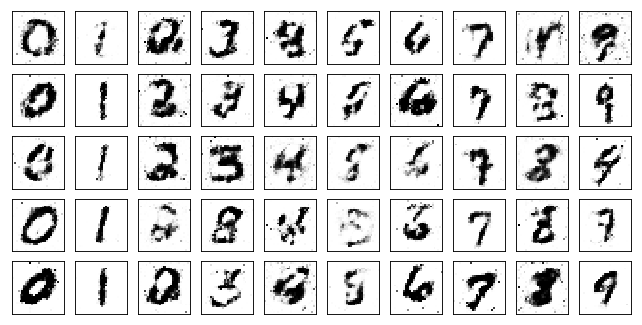

Test losses. G: 1.8259, D: 0.2850
Train Epoch: 81 [0/50000 (0%)]	Losses G: 2.1821, D: 0.3645
Train Epoch: 81 [25000/50000 (50%)]	Losses G: 1.7071, D: 0.3859
Train Epoch: 81 [50000/50000 (100%)]	Losses G: 2.8342, D: 0.3061


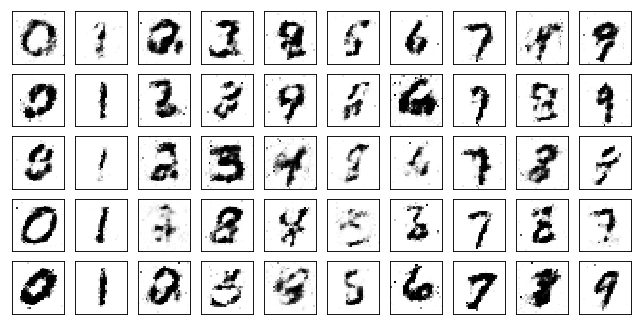

Test losses. G: 2.6655, D: 0.2573
Train Epoch: 82 [0/50000 (0%)]	Losses G: 2.7392, D: 0.3555
Train Epoch: 82 [25000/50000 (50%)]	Losses G: 2.1192, D: 0.3081
Train Epoch: 82 [50000/50000 (100%)]	Losses G: 1.9543, D: 0.3523


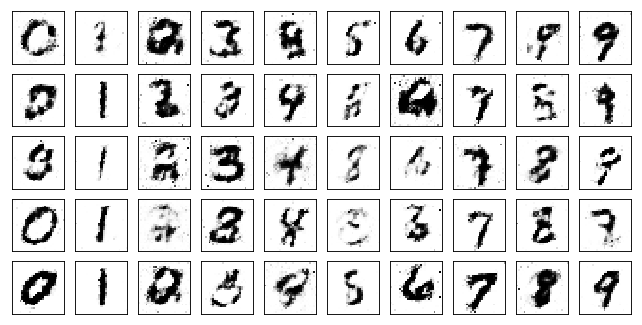

Test losses. G: 2.0233, D: 0.2448
Train Epoch: 83 [0/50000 (0%)]	Losses G: 1.9335, D: 0.3467
Train Epoch: 83 [25000/50000 (50%)]	Losses G: 1.8216, D: 0.4022
Train Epoch: 83 [50000/50000 (100%)]	Losses G: 2.1152, D: 0.3375


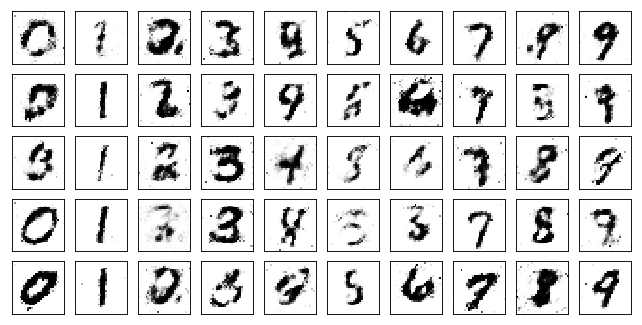

Test losses. G: 2.0704, D: 0.2845
Train Epoch: 84 [0/50000 (0%)]	Losses G: 2.0467, D: 0.3577
Train Epoch: 84 [25000/50000 (50%)]	Losses G: 2.6098, D: 0.3520
Train Epoch: 84 [50000/50000 (100%)]	Losses G: 1.9191, D: 0.4218


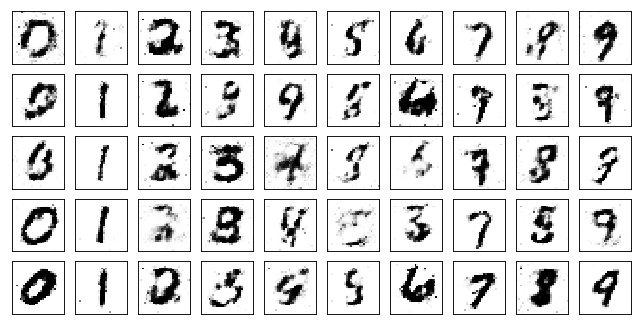

Test losses. G: 1.7376, D: 0.3033
Train Epoch: 85 [0/50000 (0%)]	Losses G: 1.9510, D: 0.4073
Train Epoch: 85 [25000/50000 (50%)]	Losses G: 1.6452, D: 0.3268
Train Epoch: 85 [50000/50000 (100%)]	Losses G: 2.3364, D: 0.3114


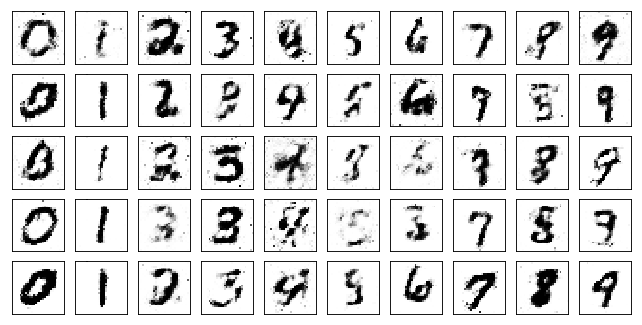

Test losses. G: 2.2645, D: 0.2486
Train Epoch: 86 [0/50000 (0%)]	Losses G: 2.2930, D: 0.3405
Train Epoch: 86 [25000/50000 (50%)]	Losses G: 2.0539, D: 0.4243
Train Epoch: 86 [50000/50000 (100%)]	Losses G: 1.8505, D: 0.4234


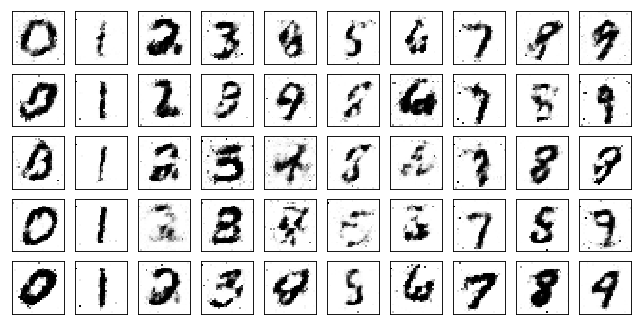

Test losses. G: 1.7678, D: 0.3355
Train Epoch: 87 [0/50000 (0%)]	Losses G: 1.8691, D: 0.3704
Train Epoch: 87 [25000/50000 (50%)]	Losses G: 1.9929, D: 0.3378
Train Epoch: 87 [50000/50000 (100%)]	Losses G: 2.0997, D: 0.4293


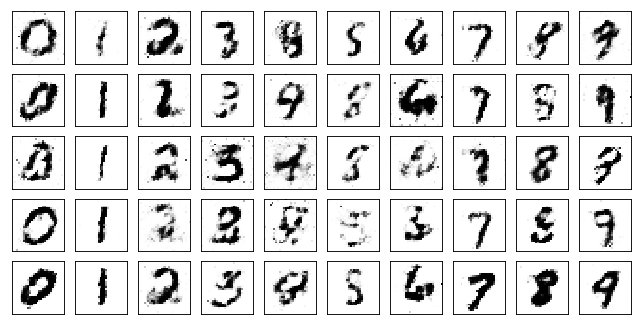

Test losses. G: 1.9685, D: 0.3337
Train Epoch: 88 [0/50000 (0%)]	Losses G: 1.7643, D: 0.4643
Train Epoch: 88 [25000/50000 (50%)]	Losses G: 1.7482, D: 0.5322
Train Epoch: 88 [50000/50000 (100%)]	Losses G: 2.1015, D: 0.3182


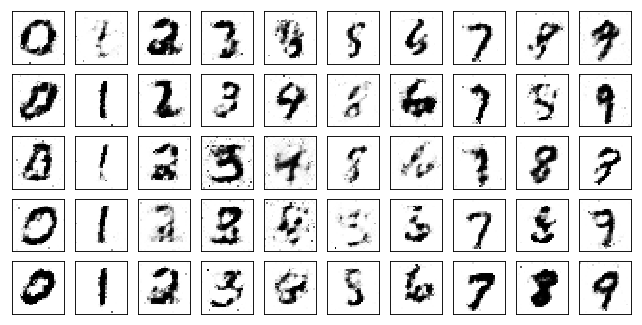

Test losses. G: 1.9767, D: 0.2568
Train Epoch: 89 [0/50000 (0%)]	Losses G: 2.4307, D: 0.3325
Train Epoch: 89 [25000/50000 (50%)]	Losses G: 1.9878, D: 0.4329
Train Epoch: 89 [50000/50000 (100%)]	Losses G: 1.7154, D: 0.4409


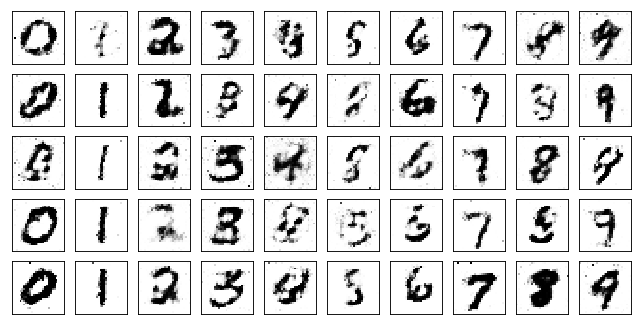

Test losses. G: 1.6247, D: 0.3386
Train Epoch: 90 [0/50000 (0%)]	Losses G: 1.6723, D: 0.4032
Train Epoch: 90 [25000/50000 (50%)]	Losses G: 1.7263, D: 0.4176
Train Epoch: 90 [50000/50000 (100%)]	Losses G: 1.7797, D: 0.3309


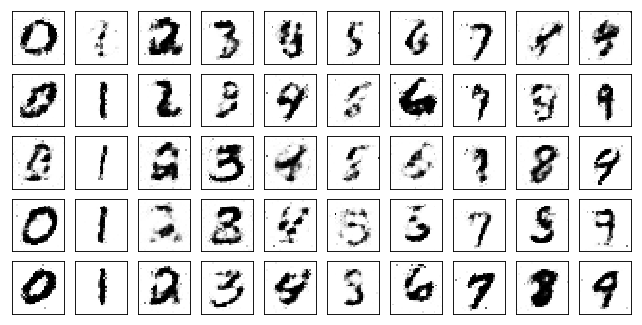

Test losses. G: 1.6919, D: 0.2928
Train Epoch: 91 [0/50000 (0%)]	Losses G: 2.0291, D: 0.3895
Train Epoch: 91 [25000/50000 (50%)]	Losses G: 1.7921, D: 0.4104
Train Epoch: 91 [50000/50000 (100%)]	Losses G: 2.0754, D: 0.3512


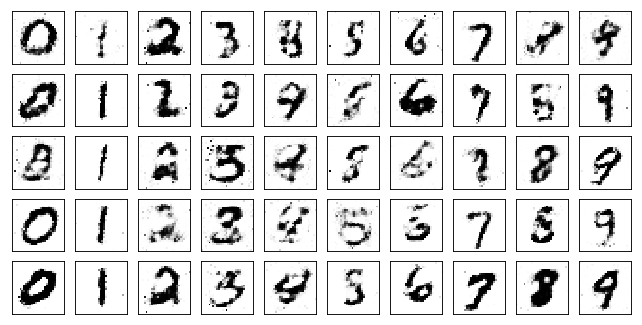

Test losses. G: 2.1025, D: 0.2855
Train Epoch: 92 [0/50000 (0%)]	Losses G: 1.8776, D: 0.3805
Train Epoch: 92 [25000/50000 (50%)]	Losses G: 1.8140, D: 0.4492
Train Epoch: 92 [50000/50000 (100%)]	Losses G: 1.7940, D: 0.4146


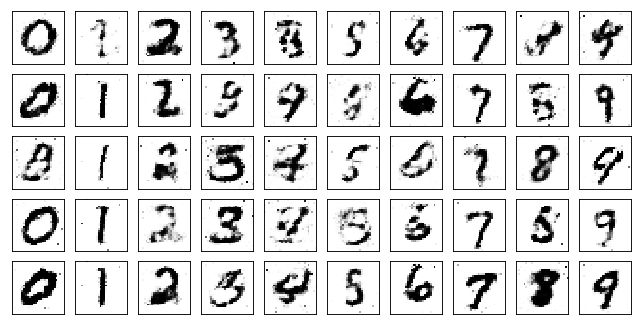

Test losses. G: 1.7198, D: 0.3307
Train Epoch: 93 [0/50000 (0%)]	Losses G: 1.9798, D: 0.4048
Train Epoch: 93 [25000/50000 (50%)]	Losses G: 2.3410, D: 0.3680
Train Epoch: 93 [50000/50000 (100%)]	Losses G: 1.7052, D: 0.5333


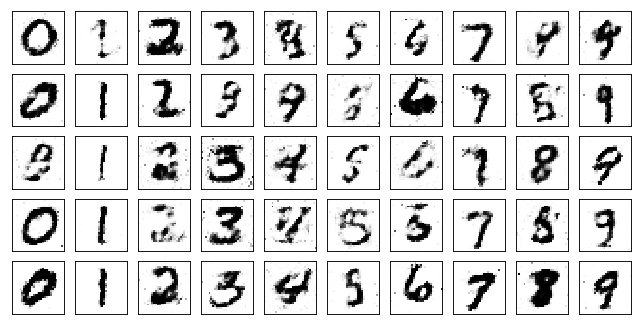

Test losses. G: 1.5305, D: 0.4330
Train Epoch: 94 [0/50000 (0%)]	Losses G: 1.5206, D: 0.5647
Train Epoch: 94 [25000/50000 (50%)]	Losses G: 1.6173, D: 0.4670
Train Epoch: 94 [50000/50000 (100%)]	Losses G: 1.7122, D: 0.3961


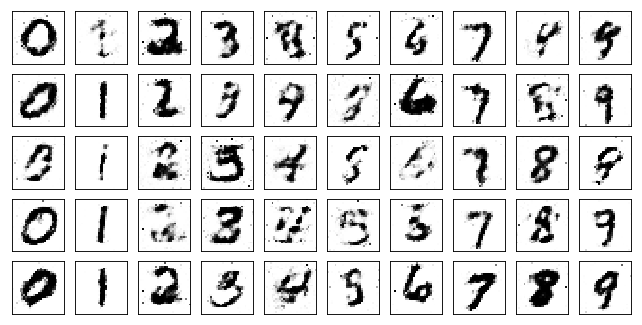

Test losses. G: 1.6368, D: 0.3294
Train Epoch: 95 [0/50000 (0%)]	Losses G: 1.6450, D: 0.4114
Train Epoch: 95 [25000/50000 (50%)]	Losses G: 1.9336, D: 0.3983
Train Epoch: 95 [50000/50000 (100%)]	Losses G: 1.9466, D: 0.3745


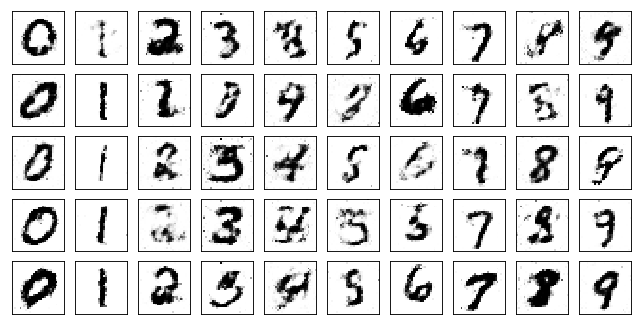

Test losses. G: 1.9742, D: 0.3233
Train Epoch: 96 [0/50000 (0%)]	Losses G: 1.9045, D: 0.3946
Train Epoch: 96 [25000/50000 (50%)]	Losses G: 2.1067, D: 0.4972
Train Epoch: 96 [50000/50000 (100%)]	Losses G: 1.5500, D: 0.4419


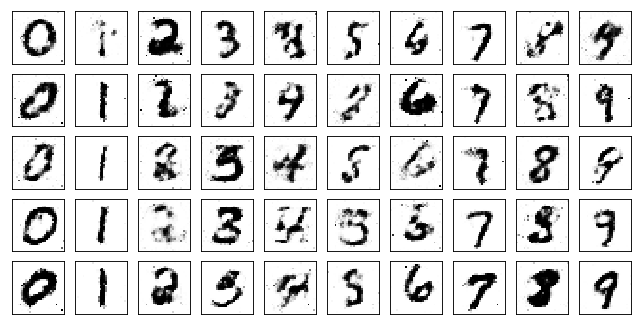

Test losses. G: 1.4755, D: 0.3803
Train Epoch: 97 [0/50000 (0%)]	Losses G: 1.7640, D: 0.4591
Train Epoch: 97 [25000/50000 (50%)]	Losses G: 1.6608, D: 0.4343
Train Epoch: 97 [50000/50000 (100%)]	Losses G: 1.8821, D: 0.4203


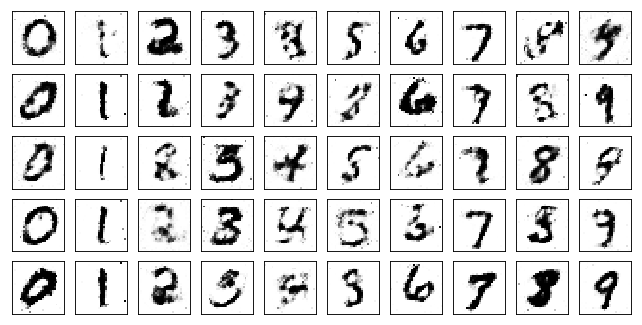

Test losses. G: 1.6809, D: 0.3515
Train Epoch: 98 [0/50000 (0%)]	Losses G: 1.6137, D: 0.4042
Train Epoch: 98 [25000/50000 (50%)]	Losses G: 1.7915, D: 0.4301
Train Epoch: 98 [50000/50000 (100%)]	Losses G: 1.5012, D: 0.4655


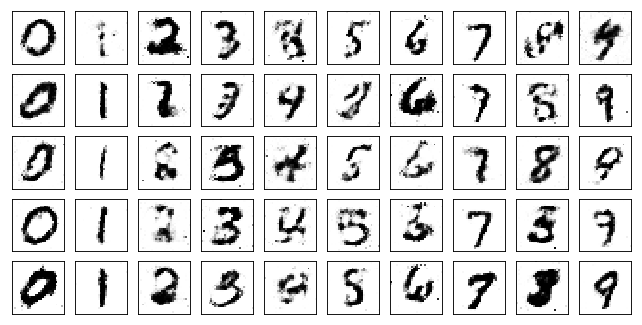

Test losses. G: 1.5794, D: 0.3756
Train Epoch: 99 [0/50000 (0%)]	Losses G: 1.5783, D: 0.4943
Train Epoch: 99 [25000/50000 (50%)]	Losses G: 2.0533, D: 0.3337
Train Epoch: 99 [50000/50000 (100%)]	Losses G: 1.9373, D: 0.3532


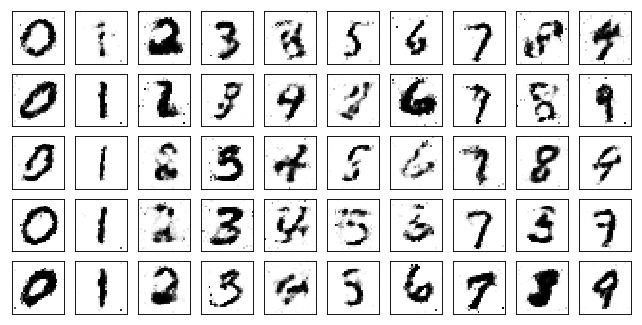

Test losses. G: 1.9299, D: 0.3131
Train Epoch: 100 [0/50000 (0%)]	Losses G: 1.7720, D: 0.3986
Train Epoch: 100 [25000/50000 (50%)]	Losses G: 1.9506, D: 0.4870
Train Epoch: 100 [50000/50000 (100%)]	Losses G: 1.6236, D: 0.4646


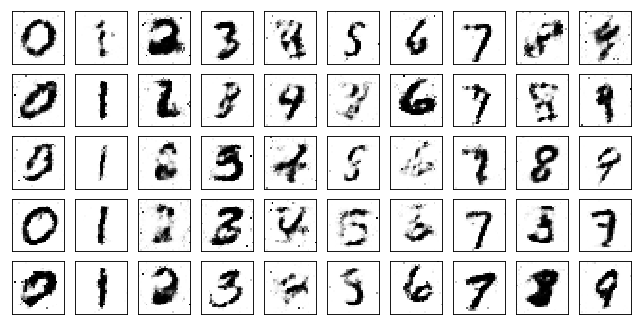

Test losses. G: 1.6154, D: 0.3906


In [12]:
for epoch in range(1, 101):
    G.train()
    D.train()
    train(epoch, G, D, train_log)
    G.eval()
    D.eval()
    test(G, D, valid_loader, epoch, test_log)